# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from scipy import stats as st

from numpy.random import RandomState

In [2]:
budget = 10_000_000_000

product_price= 450_000

well_number= 200

In [3]:
region_0 = pd.read_csv('/datasets/geo_data_0.csv')
region_1 = pd.read_csv('/datasets/geo_data_1.csv')
region_2 =pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
# Смотрю данные по первому региону

region_0.info();
region_0.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


In [5]:
# Ищу дубликаты в столбце id и удаляю их.

print(region_0['id'].duplicated().sum())

region_0 = region_0.drop_duplicates(subset=['id'], keep='first')

print(region_0['id'].duplicated().sum())

10
0


<AxesSubplot:>

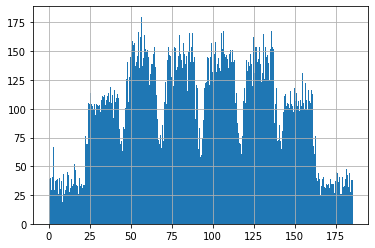

In [6]:
region_0['product'].hist(bins=1000)

<AxesSubplot:>

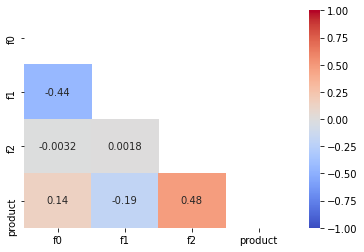

In [7]:
upp_mat = np.triu(region_0.corr())
sns.heatmap(region_0.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', mask = upp_mat)

In [8]:
# Смотрю данные по второму региону

region_1.info();
region_1.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


In [9]:
# Ищу дубликаты в столбце id и удаляю их.

print(region_1['id'].duplicated().sum())

region_1 = region_1.drop_duplicates(subset=['id'], keep='first')

print(region_1['id'].duplicated().sum())

4
0


<AxesSubplot:>

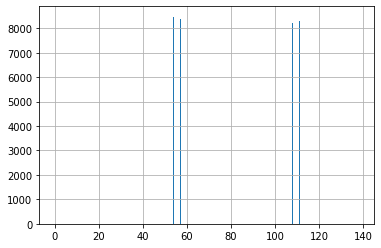

In [10]:
region_1['product'].hist(bins=1000)

In [11]:
region_1['product'].value_counts()

53.906522     8472
26.953261     8468
84.038886     8430
57.085625     8389
3.179103      8337
80.859783     8320
30.132364     8306
110.992147    8303
134.766305    8303
0.000000      8235
137.945408    8233
107.813044    8200
Name: product, dtype: int64

In [12]:
region_1['product'].describe()

count    99996.000000
mean        68.823916
std         45.944663
min          0.000000
25%         26.953261
50%         57.085625
75%        107.813044
max        137.945408
Name: product, dtype: float64

<AxesSubplot:>

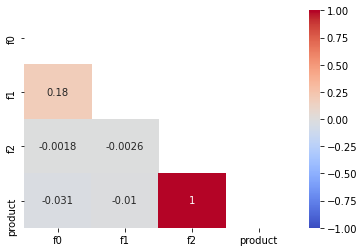

In [13]:
upp_mat = np.triu(region_1.corr())
sns.heatmap(region_1.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', mask = upp_mat)

In [14]:
# Смотрю данные по третьему региону

region_2.info();
region_2.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


In [15]:
# Ищу дубликаты в столбце id и удаляю их.

print(region_2['id'].duplicated().sum())

region_2 = region_2.drop_duplicates(subset=['id'], keep='first')

print(region_2['id'].duplicated().sum())

4
0


<AxesSubplot:>

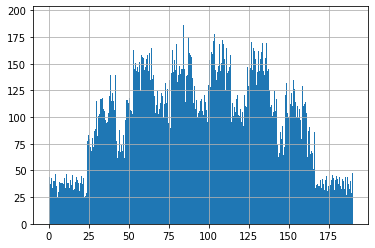

In [16]:
region_2['product'].hist(bins=1000)

<AxesSubplot:>

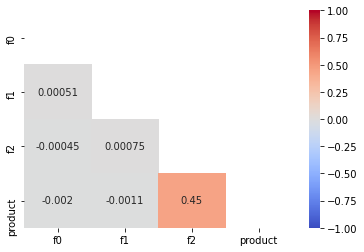

In [17]:
upp_mat = np.triu(region_2.corr())
sns.heatmap(region_2.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', mask = upp_mat)

<b>Итоги загрузки и подготовки данных:</b>

В данных нет пропусков, они готовы к работе с моделью. Дубликаты удалены. Для обучения модели необходимо исключить id скважины.

В данных второго региона наблюдается сильная корреляция между признаком product и f2. В третьем регионе корреляция между этими признаками составляет 0.45, а в первом - 0.48.

## Обучение и проверка модели

In [18]:
# Выделяю целевой признак и создаю выборки по донным первого региона

features_0 = region_0.drop(['id', 'product'], axis=1)
target_0 = region_0['product']

features_0_train, features_0_valid, target_0_train, target_0_valid = train_test_split(
    features_0, 
    target_0, 
    test_size=0.25, 
    random_state=12345
)

# Обучаю модель на данных первого региона и вычисляю средний запас предсказанного сырья и RMSE.

model_0 = LinearRegression()
model_0.fit(features_0_train, target_0_train)
predicted_0_valid = model_0.predict(features_0_valid)
rmse_0 = mean_squared_error(target_0_valid, predicted_0_valid, squared=False)

print(f'Средний запас предсказанного сырья в первом регионе: {predicted_0_valid.mean()}')
print(f'RMSE модели для первого региона: {rmse_0}')

predicted_0_valid_series = pd.Series(predicted_0_valid, index=features_0_valid.index)

Средний запас предсказанного сырья в первом регионе: 92.78915638280621
RMSE модели для первого региона: 37.853527328872964


In [19]:
# Выделяю целевой признак и создаю выборки по дaнным второго региона

features_1 = region_1.drop(['id', 'product'], axis=1)
target_1 = region_1['product']

features_1_train, features_1_valid, target_1_train, target_1_valid = train_test_split(
    features_1, 
    target_1, 
    test_size=0.25, 
    random_state=12345
)

# Обучаю модель на данных второго региона и вычисляю средний запас предсказанного сырья и RMSE.

model_1 = LinearRegression()
model_1.fit(features_1_train, target_1_train)
predicted_1_valid = model_1.predict(features_1_valid)
rmse_1 = mean_squared_error(target_1_valid, predicted_1_valid, squared=False)

print(f'Средний запас предсказанного сырья во втором регионе: {predicted_1_valid.mean()}')
print(f'RMSE модели для второго региона: {rmse_1}')

predicted_1_valid_series = pd.Series(predicted_1_valid, index=features_1_valid.index)

Средний запас предсказанного сырья во втором регионе: 69.17831957030432
RMSE модели для второго региона: 0.892059264771703


In [20]:
# Выделяю целевой признак и создаю выборки по дaнным третьего региона

features_2 = region_2.drop(['id', 'product'], axis=1)
target_2 = region_2['product']

features_2_train, features_2_valid, target_2_train, target_2_valid = train_test_split(
    features_2, 
    target_2, 
    test_size=0.25, 
    random_state=12345
)

# Обучаю модель на данных третьего региона и вычисляю средний запас предсказанного сырья и RMSE.

model_2 = LinearRegression()
model_2.fit(features_2_train, target_2_train)
predicted_2_valid = model_2.predict(features_2_valid)
rmse_2 = mean_squared_error(target_2_valid, predicted_2_valid, squared=False)

print(f'Средний запас предсказанного сырья в третьем регионе: {predicted_2_valid.mean()}')
print(f'RMSE модели для третьего региона: {rmse_2}')

predicted_2_valid_series = pd.Series(predicted_2_valid, index=features_2_valid.index)

Средний запас предсказанного сырья в третьем регионе: 94.86572480562035
RMSE модели для третьего региона: 40.07585073246016


### Итоги обучения и проверкии моделей по данным из трёх регионов.

Показатели <b>среднего запаса предсказанного сырья</b> в трёх регионах:
- Первое место занимает <b>третий регион</b>. Средний запас предсказанного сырья в третьем регионе: <b>94.96504596800489</b>
- Второе место занимает <b>первый регион</b>. Средний запас предсказанного сырья в первом регионе: <b>92.59256778438035</b>
- Третье место занимает <b>второй регион</b>. Средний запас предсказанного сырья во втором регионе: <b>68.728546895446</b>

Показатели <b>RMSE</b> моделей, обученных по данным трёх регионов:
Наиболее точной является модель для второго региона, остальные модели склонны завышать объемы сапасов в скважинах: 
- RMSE модели для <b>второго</b> региона: <b>0.893099286775617</b>
- RMSE модели для <b>первого</b> региона: <b>37.5794217150813</b>
- RMSE модели для <b>третьего</b> региона: <b>40.02970873393434</b>

## Подготовка к расчёту прибыли

In [21]:
# Вычисляю достаточный объём сырья для безубыточной разработки новой скважины

sufficient_product_volume = budget / (product_price * well_number)

print(f'Достаточный объём сырья для безубыточной разработки новой скважины: {sufficient_product_volume}')

Достаточный объём сырья для безубыточной разработки новой скважины: 111.11111111111111


### Итоги расчётов.

Расчёты показали, что скважина не будет убыточной, если <b>объём запасов в скважине</b> будет не менее <b>111.11111111111111</b> (тыс. баррелей). 

## Расчёт прибыли и рисков 

In [22]:
# Создаю функцию для определения прибыли

def product_profit(product_predictions_valid, product_target_valid, product_cost, expenses, max_number):
    product_predictions_valid = pd.Series(product_predictions_valid)
    product_predictions_valid = product_predictions_valid.sort_values(ascending=False)[:max_number]
    total_profit = (product_target_valid.iloc[product_predictions_valid.index].sum() * product_cost) - expenses
    return total_profit

In [24]:
# Определяю прибыль для 200 лучших скважин первого региона

region_0_profit = product_profit(predicted_0_valid, target_0_valid, product_price, budget, 200)

print('Суммарная прибыль 200 лучших скважин первого региона:', region_0_profit)

Суммарная прибыль 200 лучших скважин первого региона: 3365187237.700287


In [25]:
# Определяю прибыль для 200 лучших скважин второго региона

region_1_profit = product_profit(predicted_1_valid, target_1_valid, product_price, budget, 200)

print('Суммарная прибыль 200 лучших скважин второго региона:', region_1_profit)

Суммарная прибыль 200 лучших скважин второго региона: 2415086696.681511


In [26]:
# Определяю прибыль для 200 лучших скважин третьего региона

region_2_profit = product_profit(predicted_2_valid, target_2_valid, product_price, budget, 200)

print('Суммарная прибыль 200 лучших скважин третьего региона:', region_2_profit)

Суммарная прибыль 200 лучших скважин третьего региона: 2501283853.2820625


<b>Итоги расчёта прибыли и рисков для трёх регионов:</b>

- На первом месте по прибыли - <b>первый</b> регион. Суммарная прибыль 200 лучших скважин первого региона: <b>3365187237.700287</b>
- Второе место по прибыли занимает <b>третий</b> регион. Суммарная прибыль 200 лучших скважин третьего региона: <b>2501283853.2820625</b>
- Третье место по прибыли занимает <b>второй</b> регион. Суммарная прибыль 200 лучших скважин второго региона: <b>2415086696.681511</b>

## Подсчёт рисков и прибыли для каждого региона

In [27]:
target_0_valid = pd.Series(target_0_valid).reset_index(drop=True)
target_1_valid = pd.Series(target_1_valid).reset_index(drop=True)
target_2_valid = pd.Series(target_2_valid).reset_index(drop=True)

predicted_0_valid = pd.Series(predicted_0_valid)
predicted_1_valid = pd.Series(predicted_1_valid)
predicted_2_valid = pd.Series(predicted_2_valid)

In [28]:
state = RandomState(12345)

def product_profit_sample(prediction, target, max_number=200):
    sample = prediction.sample(500, replace=True, random_state=state)
    best_sample = sample.sort_values(ascending=False)[:max_number]
    best_target = target[best_sample.index]
    total_profit = (best_target.sum() * product_price) - budget
    return total_profit

In [29]:
# Применяю технику Bootstrap с 1000 повторений, чтобы найти распределение прибыли для первого региона.

region_0_total_profit = []

for i in range(1000):
    region_0_total_profit.append(product_profit_sample(predicted_0_valid, target_0_valid))

region_0_total_profit = pd.Series(region_0_total_profit)

print('Средняя прибыль первого региона:', region_0_total_profit.mean())

region_0_confidence_interval = [region_0_total_profit.quantile(0.025), region_0_total_profit.quantile(0.975)]

print('95%-й доверительный интервал первого региона:', region_0_confidence_interval)

region_0_total_losses = []

for i in region_0_total_profit:
    if i < 0:
        region_0_total_losses.append(i)
        
print('Доля убытков для первого региона составляет:', len(region_0_total_losses)/len(region_0_total_profit))
        

Средняя прибыль первого региона: 380613470.0175977
95%-й доверительный интервал первого региона: [-142942739.74041605, 890976833.8485551]
Доля убытков для первого региона составляет: 0.077


In [30]:
print('Средняя прибыль одной скважины первого региона:', 380613470.0175977 / 200)

Средняя прибыль одной скважины первого региона: 1903067.3500879884


In [31]:
# Применяю технику Bootstrap с 1000 повторений, чтобы найти распределение прибыли для второго региона.

region_1_total_profit = []

for i in range(1000):
    region_1_total_profit.append(product_profit_sample(predicted_1_valid, target_1_valid))

region_1_total_profit = pd.Series(region_1_total_profit)

print('Средняя прибыль второго региона:', region_1_total_profit.mean())


region_1_confidence_interval = [region_1_total_profit.quantile(0.025), region_1_total_profit.quantile(0.975)]

print('95%-й доверительный интервал второго региона:', region_1_confidence_interval)

region_1_total_losses = []

for i in region_1_total_profit:
    if i < 0:
        region_1_total_losses.append(i)
        
print('Доля убытков для второго региона составляет:', len(region_1_total_losses)/len(region_1_total_profit))

Средняя прибыль второго региона: 479159869.981588
95%-й доверительный интервал второго региона: [73849212.0224793, 917953817.7221825]
Доля убытков для второго региона составляет: 0.006


In [32]:
print('Средняя прибыль одной скважины второго региона:', 479159869.981588 / 200)

Средняя прибыль одной скважины второго региона: 2395799.3499079403


In [33]:
# Применяю технику Bootstrap с 1000 повторений, чтобы найти распределение прибыли для третьего региона.

region_2_total_profit = []

for i in range(1000):
    region_2_total_profit.append(product_profit_sample(predicted_2_valid, target_2_valid))

region_2_total_profit = pd.Series(region_2_total_profit)

print('Средняя прибыль третьего региона:', region_2_total_profit.mean())

region_2_confidence_interval = [region_2_total_profit.quantile(0.025), region_2_total_profit.quantile(0.975)]

print('95%-й доверительный интервал третьего региона:', region_2_confidence_interval)

region_2_total_losses = []

for i in region_2_total_profit:
    if i < 0:
        region_2_total_losses.append(i)
        
print('Доля убытков для третьего региона составляет:', len(region_2_total_losses)/len(region_2_total_profit))

Средняя прибыль третьего региона: 315441916.0234899
95%-й доверительный интервал третьего региона: [-216265050.0341763, 811060708.2365634]
Доля убытков для третьего региона составляет: 0.124


In [34]:
print('Средняя прибыль одной скважины третьего региона:', 315441916.0234899 / 200)

Средняя прибыль одной скважины третьего региона: 1577209.5801174494


Были выполнены следующие действия:

1. Загрузка и подготовка данных

В данных нет пропусков, они готовы к работе с моделью. Дубликаты удалены. Для обучения модели необходимо исключить id скважины.

В данных второго региона наблюдается сильная корреляция между признаком product и f2. В третьем регионе корреляция между этими признаками составляет 0.45, а в первом - 0.48.

2.  Обучение и проверка модели

Показатели <b>среднего запаса предсказанного сырья</b> в трёх регионах:
- Первое место занимает <b>третий регион</b>. Средний запас предсказанного сырья в третьем регионе: <b>94.96504596800489</b>
- Второе место занимает <b>первый регион</b>. Средний запас предсказанного сырья в первом регионе: <b>92.59256778438035</b>
- Третье место занимает <b>второй регион</b>. Средний запас предсказанного сырья во втором регионе: <b>68.728546895446</b>

Показатели <b>RMSE</b> моделей, обученных по данным трёх регионов:
Наиболее точной является модель для второго региона, остальные модели склонны завышать объемы сапасов в скважинах: 
- RMSE модели для <b>второго</b> региона: <b>0.893099286775617</b>
- RMSE модели для <b>первого</b> региона: <b>37.5794217150813</b>
- RMSE модели для <b>третьего</b> региона: <b>40.02970873393434</b>

3.  Подготовка к расчёту прибыли

Расчёты показали, что скважина не будет убыточной, если <b>объём запасов в скважине</b> будет не менее <b>111.11111111111111</b> (тыс. баррелей). 

4.  Расчёт прибыли и рисков

- На первом месте по прибыли - <b>первый</b> регион. Суммарная прибыль 200 лучших скважин первого региона: <b>3365187237.700287</b>
- Второе место по прибыли занимает <b>третий</b> регион. Суммарная прибыль 200 лучших скважин третьего региона: <b>2501283853.2820625</b>
- Третье место по прибыли занимает <b>второй</b> регион. Суммарная прибыль 200 лучших скважин второго региона: <b>2415086696.681511</b>

5. Подсчёт рисков и прибыли для каждого региона

Первый регион:
- Средняя прибыль первого региона: 380613470.0175977
- Средняя прибыль одной скважины первого региона: 1903067.3500879884
- 95%-й доверительный интервал первого региона: [-142942739.74041605, 890976833.8485551]
- Доля убытков для первого региона составляет: 0.077

Второй регион:
- Средняя прибыль второго региона: 479159869.981588
- Средняя прибыль одной скважины второго региона: 2395799.3499079403
- 95%-й доверительный интервал второго региона: [73849212.0224793, 917953817.7221825]
- Доля убытков для второго региона составляет: 0.006

Третий регион:
- Средняя прибыль третьего региона: 315441916.0234899
- Средняя прибыль одной скважины третьего региона: 1577209.5801174494
- 95%-й доверительный интервал третьего региона: [-216265050.0341763, 811060708.2365634]
- Доля убытков для третьего региона составляет: 0.124

<b>Вывод</b>

Регионом с самым высоким значением средней прибыли и минимальными рисками является <b>второй</b>. В первом регионе значение средней прибыли ниже, а риски значительно выше. В третьем регионе средняя прибыль ещё ниже, а риски ещё выше. 